[DataSet](https://www.kaggle.com/datasets/ramoliyafenil/text-based-cyber-threat-detection)

## Data Loading & Cleaning

In [1]:
import pandas as pd
df = pd.read_csv("/content/cyber-threat-intelligence_all.csv")
df = df[["text","label"]]
df = df.dropna()
df.head()

,text,label
0,This post is also available in: 日本語 (Japa...,malware
1,The attack vector is very basic and repeats it...,attack-pattern
3,The first known campaign was launched by Crim...,TIME
5,A very serious campaign was launched between ...,identity
8,Palo Alto Networks Enterprise Security Platfo...,identity


In [2]:
print(df.shape)

(9938, 2)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9938 entries, 0 to 19939
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9938 non-null   object
 1   label   9938 non-null   object
dtypes: object(2)
memory usage: 232.9+ KB


<Axes: xlabel='label'>

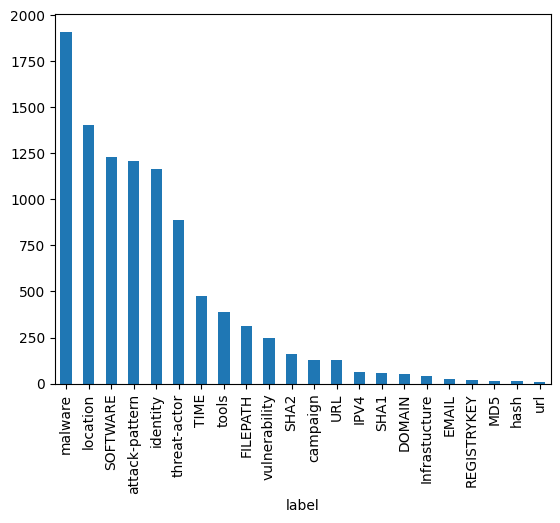

In [4]:
df['label'].value_counts(sort=True).plot(kind='bar')

In [5]:
df['label'].value_counts(sort=True)

,count
label,
malware,1911
location,1405
SOFTWARE,1229
attack-pattern,1206
identity,1165
threat-actor,890
TIME,475
tools,391
FILEPATH,313


## Pre-Processing

In [6]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)
df.head()

,text,label
0,this post is also available in japanese ctbloc...,malware
1,the attack vector is very basic and repeats it...,attack-pattern
3,the first known campaign was launched by crime...,TIME
5,a very serious campaign was launched between j...,identity
8,palo alto networks enterprise security platfor...,identity


In [7]:
import tensorflow as tf
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [row.split() for row in df['text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X = padded_sequences

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2,stratify=y_encoded, random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7950, 450)
(1988, 450)
(7950, 22)
(1988, 22)


## Modeling

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dense, Dropout
from tensorflow.keras import mixed_precision


### GRU - AttentionLayer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, GRU, Dense, Dropout, Layer
from tensorflow.keras.models import Model

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        # Calculate attention scores
        attention_scores = tf.nn.softmax(tf.linalg.matmul(inputs, inputs, transpose_b=True))
        # Calculate the context vector
        context_vector = tf.linalg.matmul(attention_scores, inputs)
        return context_vector[:, -1, :]


input_length = 450
input_dim = 10000
embedding_dim = 128

input_layer = Input(shape=(input_length,))
embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim)(input_layer)
dropout_layer = SpatialDropout1D(0.2)(embedding_layer)

gru_layer = GRU(128, return_sequences=True)(dropout_layer)
attention_output = AttentionLayer()(gru_layer)

dense_layer_1 = Dense(64, activation='relu')(attention_output)
dropout_dense_1 = Dropout(0.3)(dense_layer_1)

output_layer = Dense(22, activation='softmax')(dropout_dense_1)

model7 = Model(inputs=input_layer, outputs=output_layer)

model7.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=["accuracy", "AUC"])

model7.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 450)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 450, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_4                  │ (None, 450, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 450, 128)            │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 22)                  │           1,430 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,388,758 (5.30 MB)

 Trainable params: 1,388,758 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rm -rf ./logs/

In [ ]:
history = model7.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - AUC: 0.6575 - accuracy: 0.0808 - loss: 2.9357 - val_AUC: 0.7954 - val_accuracy: 0.1172 - val_loss: 2.5322
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - AUC: 0.7709 - accuracy: 0.1326 - loss: 2.6785 - val_AUC: 0.8125 - val_accuracy: 0.1237 - val_loss: 2.4972
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - AUC: 0.7880 - accuracy: 0.1425 - loss: 2.6055 - val_AUC: 0.8184 - val_accuracy: 0.1922 - val_loss: 2.4632
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - AUC: 0.7984 - accuracy: 0.1515 - loss: 2.5577 - val_AUC: 0.8243 - val_accuracy: 0.1922 - val_loss: 2.4293
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - AUC: 0.8117 - accuracy: 0.1447 - loss: 2.5019 - val_AUC: 0.8333 - val_accuracy: 0.1937 - val_loss: 2.3923
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - AUC: 0.8262 - accuracy: 0.1552 - loss: 2.4428 - val_AUC: 0.8395 - val_accuracy: 0.1987 - val_loss: 2.3431
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - 

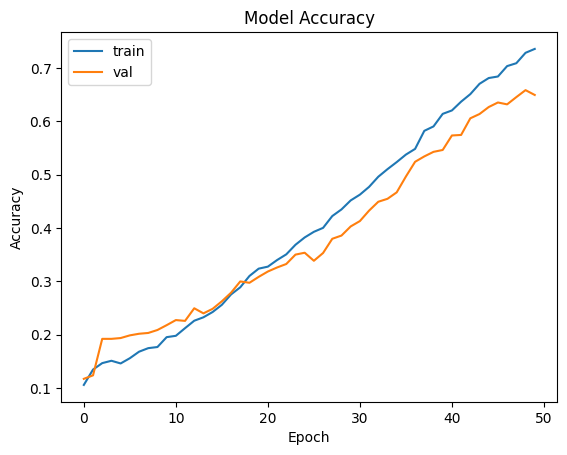

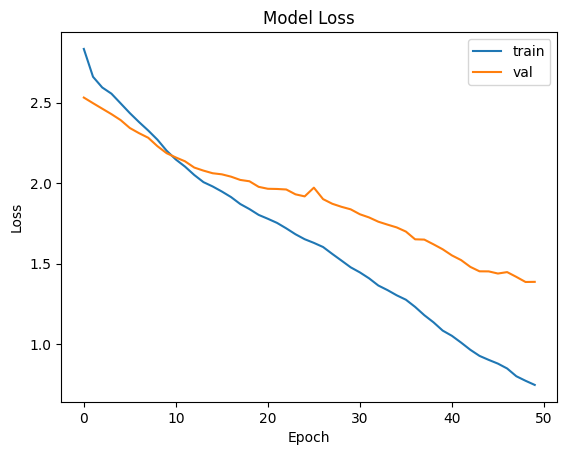

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


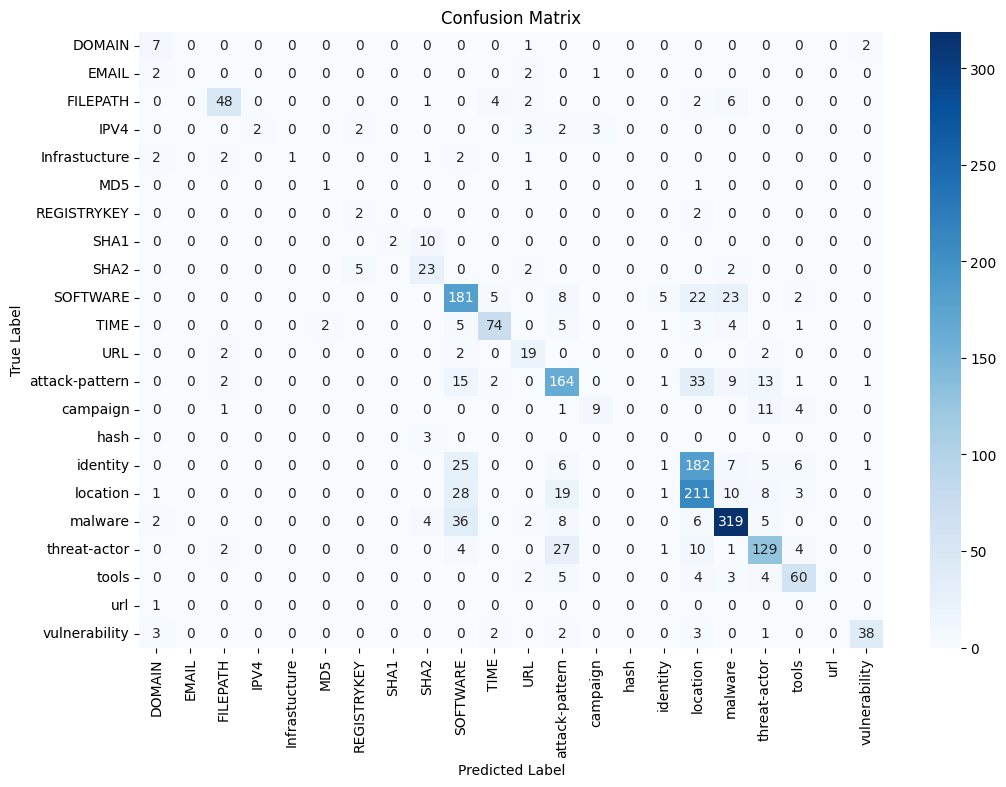

In [ ]:
y_pred_prob = model7.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            fmt='.0f',
            cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### LSTM

In [ ]:
input_dim = len(tokenizer.word_index) + 1
embedding_dim = 100
input_length = 450

input_layer = Input(shape=(input_length,))

embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim)(input_layer)
dropout_layer = SpatialDropout1D(0.2)(embedding_layer)

lstm_layer_1 = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(dropout_layer)
lstm_layer_2 = LSTM(64,  recurrent_dropout=0.2)(lstm_layer_1)
dense_layer_1 = Dense(64, activation='relu')(lstm_layer_2)
dropout_dense_1 = Dropout(0.3)(dense_layer_1)

dense_layer_2 = Dense(32, activation='relu')(dropout_dense_1)
dropout_dense_2 = Dropout(0.3)(dense_layer_2)

output_layer = Dense(22, activation='softmax')(dropout_dense_2)

model1 = Model(inputs=input_layer, outputs=output_layer)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

model1.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=["accuracy", "AUC"])

model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 450)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 450, 100)            │         939,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 450, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 450, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 22)                  │             726 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,112,622 (4.24 MB)

 Trainable params: 1,112,622 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rm -rf ./logs/

In [ ]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - AUC: 0.5901 - accuracy: 0.1157 - loss: 3.0653 - val_AUC: 0.7507 - val_accuracy: 0.1922 - val_loss: 2.7787
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - AUC: 0.7179 - accuracy: 0.1634 - loss: 2.8175 - val_AUC: 0.7811 - val_accuracy: 0.1922 - val_loss: 2.6776
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - AUC: 0.7519 - accuracy: 0.1463 - loss: 2.7336 - val_AUC: 0.7988 - val_accuracy: 0.1922 - val_loss: 2.5737
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - AUC: 0.7705 - accuracy: 0.1445 - loss: 2.6740 - val_AUC: 0.8122 - val_accuracy: 0.1922 - val_loss: 2.5228
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - AUC: 0.7817 - accuracy: 0.1584 - loss: 2.6309 - val_AUC: 0.8178 - val_accuracy: 0.1922 - val_loss: 2.4964
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - AUC: 0.7866 - accuracy: 0.1559 - loss: 2.6141 - val_AUC: 0.8210 - val_accuracy: 0.1922 - val_loss: 2.4667
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - AUC: 0.7952 - 

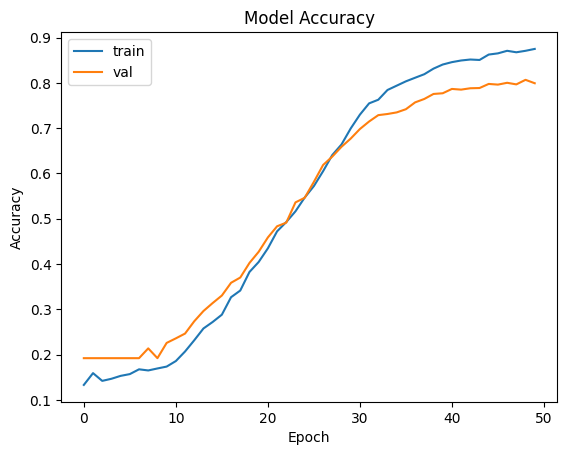

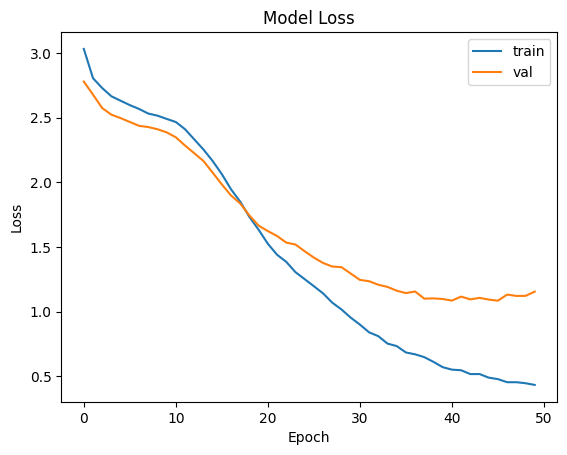

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step


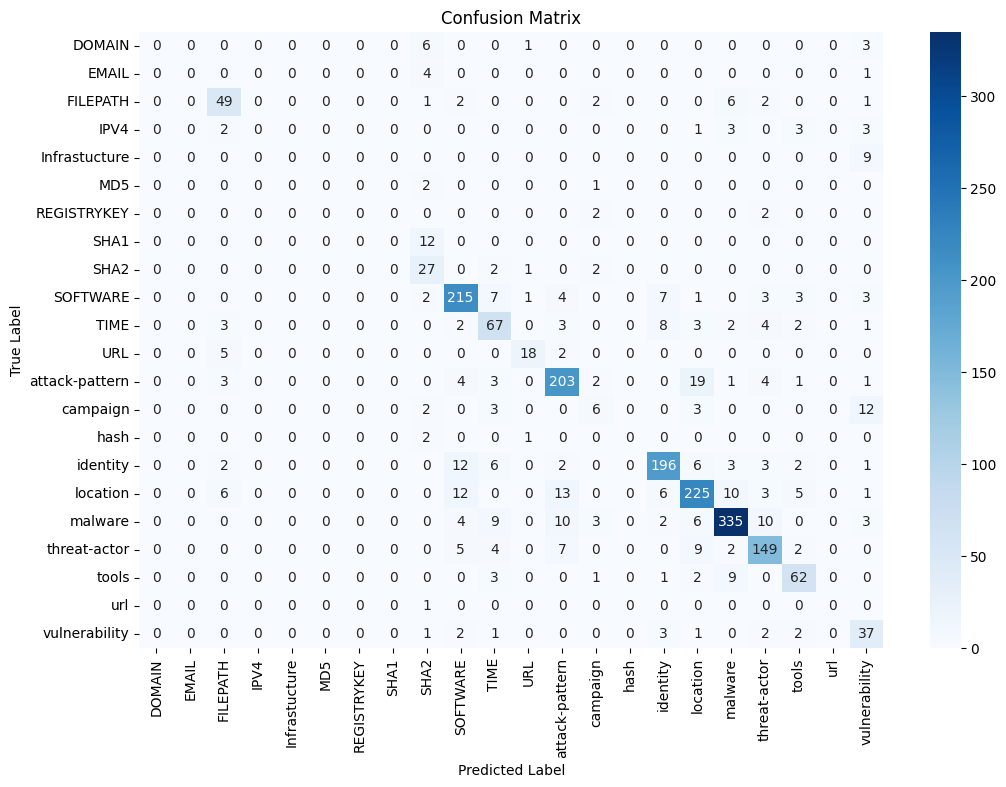

In [ ]:
y_pred_prob = model1.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            fmt='.0f',
            cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Bidirectional - LSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional

input_layer = Input(shape=(input_length,))

embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim)(input_layer)
dropout_layer = SpatialDropout1D(0.2)(embedding_layer)

bi_lstm_layer_1 = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2))(dropout_layer)
bi_lstm_layer_2 = Bidirectional(LSTM(64, recurrent_dropout=0.2))(bi_lstm_layer_1)

dense_layer_1 = Dense(64, activation='relu')(bi_lstm_layer_2)
dropout_dense_1 = Dropout(0.3)(dense_layer_1)

output_layer = Dense(22, activation='softmax')(dropout_dense_1)

model4 = Model(inputs=input_layer, outputs=output_layer)

model4.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=["accuracy", "AUC"])

model4.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 450)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 450, 100)            │         939,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 450, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 450, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 22)                  │           1,430 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,347,534 (5.14 MB)

 Trainable params: 1,347,534 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rm -rf ./logs/

In [ ]:
history = model4.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - AUC: 0.6623 - accuracy: 0.1222 - loss: 2.9893 - val_AUC: 0.8106 - val_accuracy: 0.1922 - val_loss: 2.5289
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - AUC: 0.7910 - accuracy: 0.1648 - loss: 2.5926 - val_AUC: 0.8283 - val_accuracy: 0.1922 - val_loss: 2.4216
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - AUC: 0.8063 - accuracy: 0.1807 - loss: 2.5211 - val_AUC: 0.8346 - val_accuracy: 0.2223 - val_loss: 2.3932
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - AUC: 0.8167 - accuracy: 0.1976 - loss: 2.4661 - val_AUC: 0.8444 - val_accuracy: 0.2460 - val_loss: 2.3347
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - AUC: 0.8339 - accuracy: 0.2454 - loss: 2.3720 - val_AUC: 0.8568 - val_accuracy: 0.2691 - val_loss: 2.2573
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - AUC: 0.8516 - accuracy: 0.2812 - loss: 2.2700 - val_AUC: 0.8646 - val_accuracy: 0.3018 - val_loss: 2.1908
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - AUC: 0.8644 - 

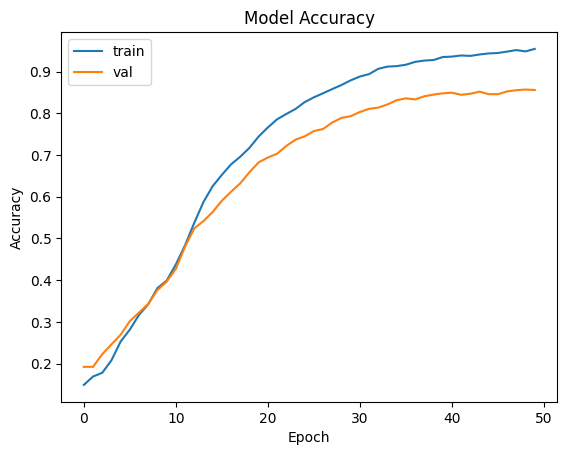

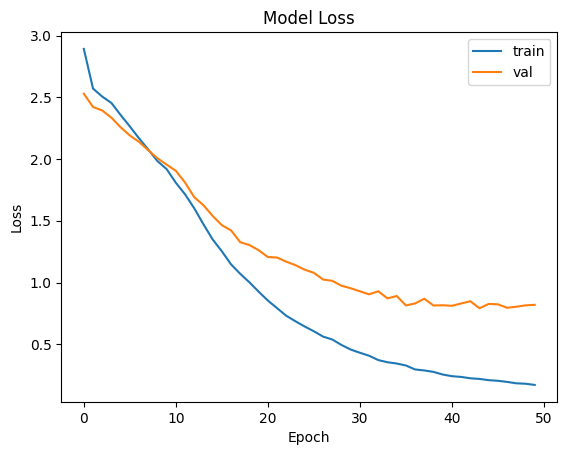

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 790ms/step


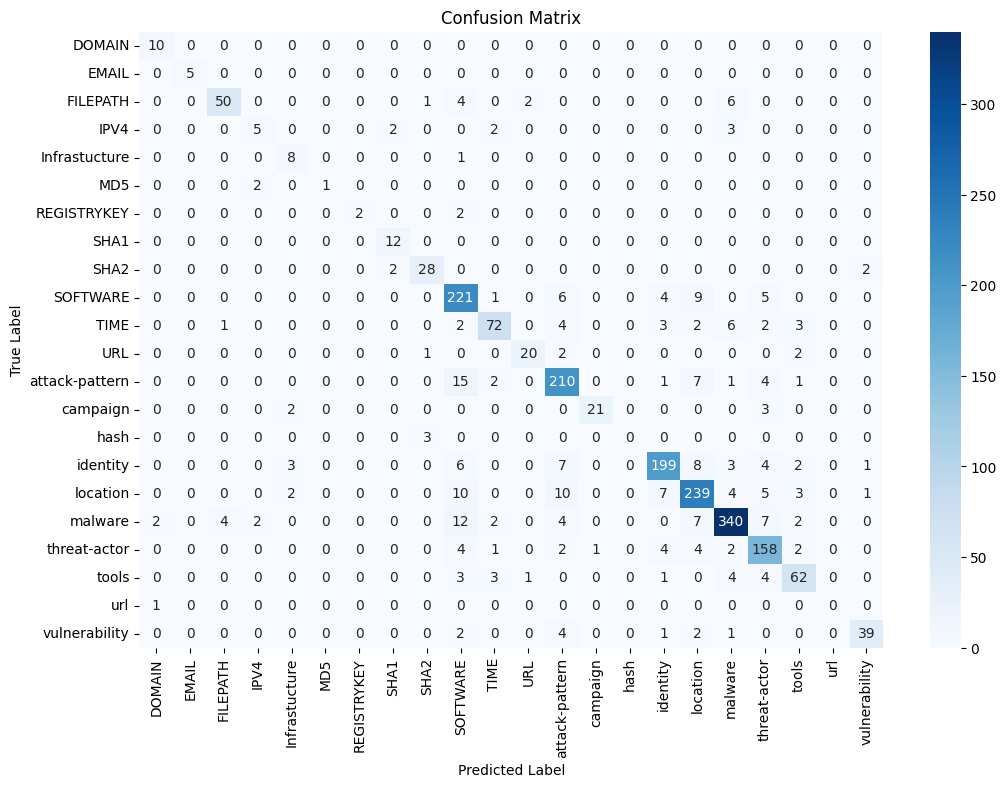

In [ ]:
y_pred_prob = model4.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            fmt='.0f',
            cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### DNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, SpatialDropout1D
from tensorflow.keras import mixed_precision

input_dim = len(tokenizer.word_index) + 1
embedding_dim = 100
input_length = 450

input_layer = Input(shape=(input_length,))

embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim)(input_layer)
dropout_layer = SpatialDropout1D(0.2)(embedding_layer)

conv_layer_1 = Conv1D(filters=128, kernel_size=5, activation='relu')(dropout_layer)
pool_layer_1 = GlobalMaxPooling1D()(conv_layer_1)

dense_layer_1 = Dense(64, activation='relu')(pool_layer_1)
dropout_dense_1 = Dropout(0.3)(dense_layer_1)

dense_layer_2 = Dense(32, activation='relu')(dropout_dense_1)
dropout_dense_2 = Dropout(0.3)(dense_layer_2)

output_layer = Dense(22, activation='softmax')(dropout_dense_2)

model3 = Model(inputs=input_layer, outputs=output_layer)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

model3.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=["accuracy", "AUC"])

model3.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 450)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 450, 100)            │         939,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 450, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 446, 128)            │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 22)                  │             726 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,014,190 (3.87 MB)

 Trainable params: 1,014,190 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rm -rf ./logs/

In [ ]:
history = model3.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_test, y_test))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - AUC: 0.6197 - accuracy: 0.1199 - loss: 3.0369 - val_AUC: 0.7105 - val_accuracy: 0.1413 - val_loss: 2.8491
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.6936 - accuracy: 0.1513 - loss: 2.8554 - val_AUC: 0.7813 - val_accuracy: 0.1413 - val_loss: 2.6632
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.7499 - accuracy: 0.1544 - loss: 2.7236 - val_AUC: 0.7967 - val_accuracy: 0.1937 - val_loss: 2.5632
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.7732 - accuracy: 0.1563 - loss: 2.6516 - val_AUC: 0.8205 - val_accuracy: 0.2067 - val_loss: 2.4896
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - AUC: 0.7934 - accuracy: 0.1784 - loss: 2.5760 - val_AUC: 0.8382 - val_accuracy: 0.2082 - val_loss: 2.4225
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - AUC: 0.8081 - accuracy: 0.1886 - loss: 2.5064 - val_AUC: 0.8511 - val_accuracy: 0.2414 - val_loss: 2.3594
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - AUC: 0.8

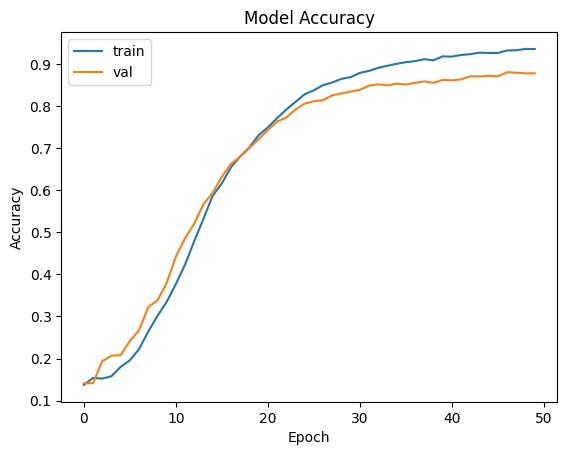

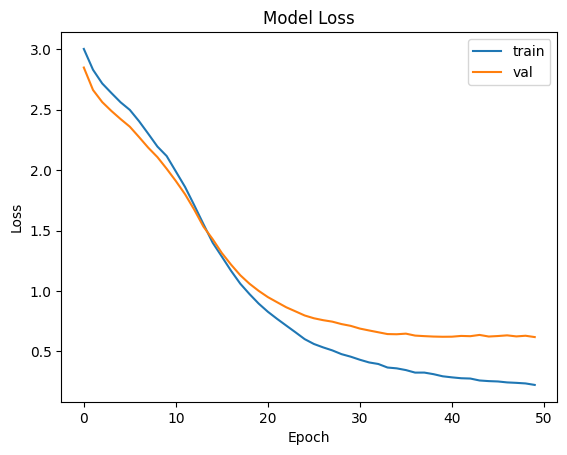

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


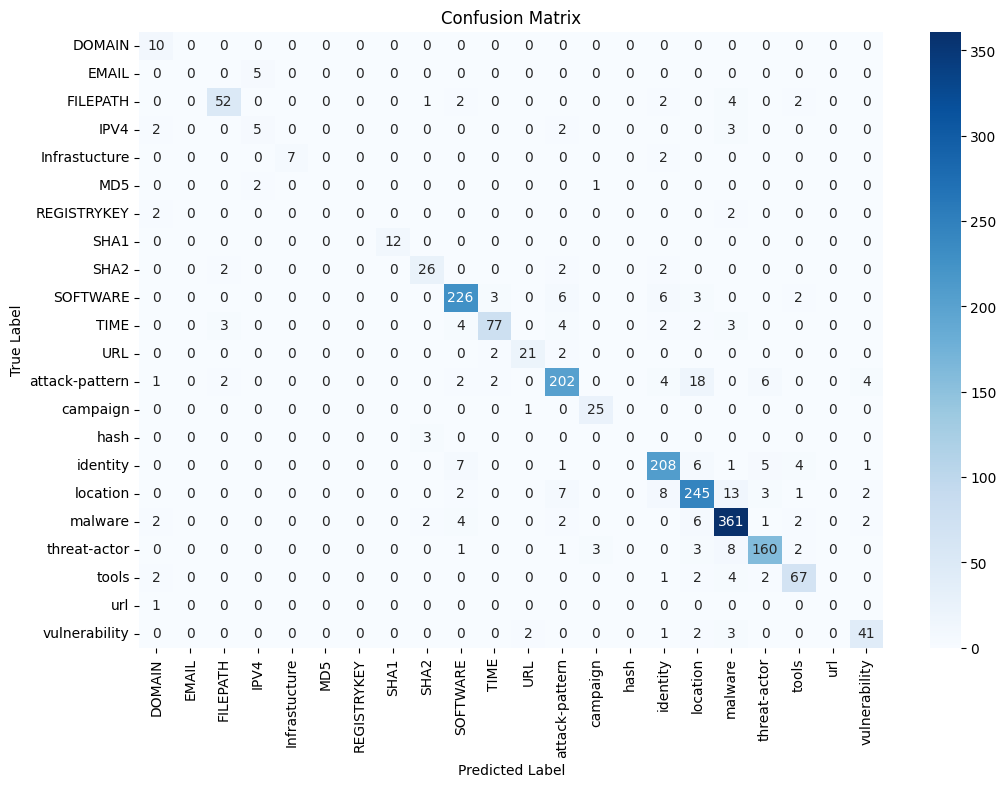

In [ ]:
y_pred_prob = model3.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            fmt='.0f',
            cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Transformer

In [12]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.layers import GlobalMaxPooling1D

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads, drop_rate=0):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=heads, key_dim=embed_size)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = Dense(embed_size, activation='relu')
        self.dropout1 = Dropout(drop_rate)
        self.dropout2 = Dropout(drop_rate)

    def call(self, x):
        attn_output = self.attention(x, x)
        x = self.norm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        return self.norm2(x + self.dropout2(ffn_output))

input_dim = len(tokenizer.word_index) + 1
embedding_dim = 100
input_length = 450

input_layer = Input(shape=(input_length,))

embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_dim)(input_layer)
dropout_layer = SpatialDropout1D(0.2)(embedding_layer)

transformer_block = TransformerBlock(embed_size=embedding_dim, heads=4)(dropout_layer)

pool_layer = GlobalMaxPooling1D()(transformer_block)

dense_layer_1 = Dense(64, activation='relu')(pool_layer)
dropout_dense_1 = Dropout(0.3)(dense_layer_1)

output_layer = Dense(22, activation='softmax')(dropout_dense_1)

model5 = Model(inputs=input_layer, outputs=output_layer)

model5.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=["accuracy", "AUC"])

model5.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 450)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 450, 100)            │         939,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 450, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 450, 100)            │         171,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 22)                  │           1,430 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,118,694 (4.27 MB)

 Trainable params: 1,118,694 (4.27 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
rm -rf ./logs/

In [10]:
history = model5.fit(X_train, y_train, epochs=50, batch_size=1024, validation_data=(X_test, y_test))

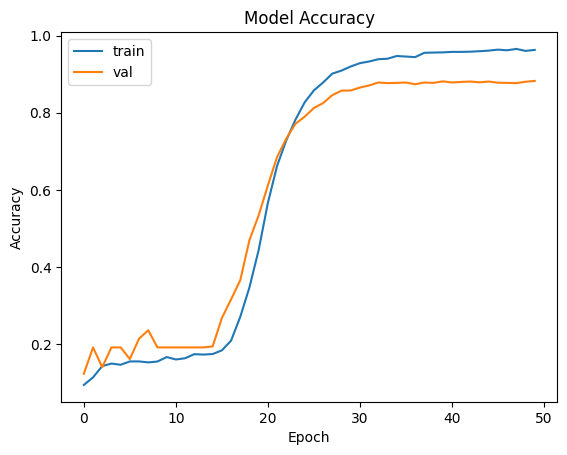

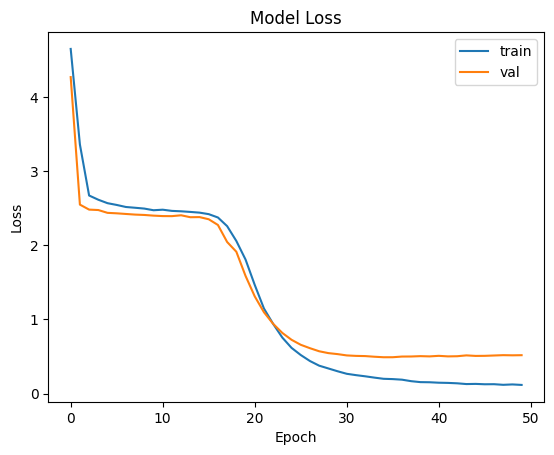

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


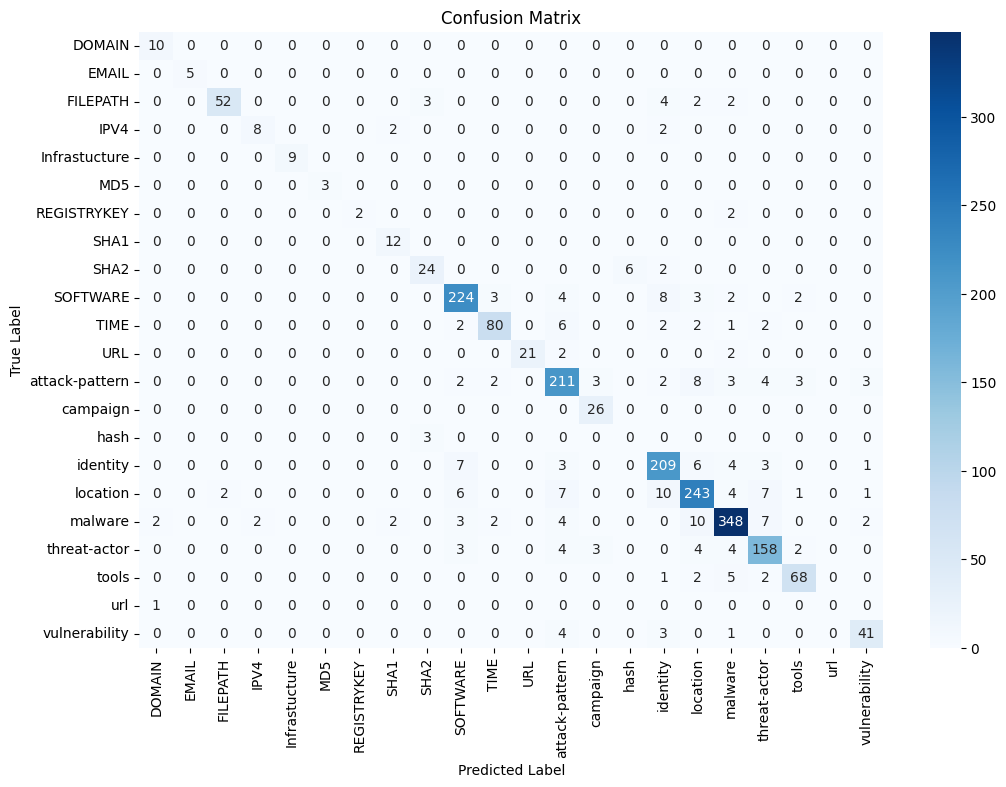

In [ ]:
y_pred_prob = model5.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))

sns.heatmap(conf_matrix, annot=True,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            fmt='.0f',
            cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
input_string = "the attack vector is very basic and repeats itself it begins with a spear phishing email sent with scr attachments double zipped"

cleaned_text = clean_text(input_string)
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=input_length)
prediction = model5.predict(padded_sequence)
predicted_class = np.argmax(prediction, axis=1)
predicted_label = label_encoder.inverse_transform(predicted_class)
predicted_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array(['attack-pattern'], dtype=object)